In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

from utils.metrics import find_rank, find_quantile_index, compute_cdf
from utils.plot_config import set_matplotlib_config, blend_legend_color_with_alpha, blend_with_alpha

set_matplotlib_config()
SAVE_DIR = Path('./figures/')
EXPECTILE_RUN = Path(
    '/net/argon/landclim/kraftb/machflow_engression/runs_quantiles/default/xval/fold_000/preds.zarr/')
ENGRESSION_RUN = Path(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/')

Matplotlib is building the font cache; this may take a moment.


In [2]:
exp = xr.open_zarr(
    EXPECTILE_RUN
).isel(time=slice(365, None)).sel(time=slice('2017', '2022'))
exp = exp.where((exp.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

eng = xr.open_zarr(
    ENGRESSION_RUN
).sel(beta=0.67, esl=5, nl=100).sel(time=slice('2017', '2022'))
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

pred_eng = eng.Qmm_mod
obs_eng = eng.Qmm
pred_eng = pred_eng.where(obs_eng, drop=True)

pred_exp = exp.Qmm_mod
obs_exp = exp.Qmm
pred_exp = pred_exp.where(obs_exp, drop=True)

In [3]:
ranks = xr.apply_ufunc(
    find_rank,
    obs_exp.compute(),                  # Observations with ["time"]
    pred_exp.compute(),                 # Expectile predictions with ["member", "time"]
    input_core_dims=[[], ['member']],   # Observations have no "member" dim, members do
    output_core_dims=[[]],              # Output is scalar per observation
    vectorize=True,                     # Apply function element-wise
    dask='parallelized',                # Enable Dask parallelization if needed
    output_dtypes=[np.float32],         # Output type
)
ranks = ranks.where(ranks!=-1, np.nan)
expectile_indices = ranks - 1
expectiles = pred_exp.member.values[1:-1]

cdf = xr.apply_ufunc(
    compute_cdf,
    expectile_indices,            # Observations with ["time"]
    input_core_dims=[['time']],   # Observations have no "quantile", quantiles do
    output_core_dims=[['time']],  # Output is scalar per observation
    exclude_dims={'time'},
    vectorize=True,               # Apply function element-wise
    dask="parallelized",          # Enable Dask parallelization if needed
    output_dtypes=[np.float32],   # Output type
    kwargs={'num_quantiles': len(expectiles)}
)
cdf = cdf.rename({'time': 'quantile'})
cdf['quantile'] = expectiles
cdf = xr.Dataset({'cdf': cdf})

cdf['rss'] = ((cdf['cdf'] - cdf['quantile']) ** 2).sum(dim='quantile')
cdf['nse'] = 1 - ((obs_exp - pred_exp.sel(member=0.5)) ** 2).sum('time') / ((obs_exp - obs_exp.mean('time')) ** 2).sum('time')

cdf_df = cdf['cdf'].to_dataframe(name='CDF').reset_index()
rss_df = cdf['rss'].to_dataframe(name='RSS').reset_index()

NSE = 1 - ((obs_exp - pred_exp.sel(member=0.5)) ** 2).sum('time') / ((obs_eng - obs_eng.mean('time')) ** 2).sum('time')
nse_df = NSE.to_dataframe(name='NSE').reset_index()
metric_df = pd.merge(rss_df, nse_df)

metric_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL'}, inplace=True)
cdf_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL', 'quantile': 'Quantile'}, inplace=True)

cdf_exp = cdf
metric_exp_df = metric_df
cdf_exp_df = cdf_df

In [4]:
quantiles = np.arange(start=0.01, stop=1.0, step=0.01)
quantile_values = pred_eng.quantile(quantiles, dim='member', skipna=False)

quantile_indices = xr.apply_ufunc(
    find_quantile_index,
    obs_eng,                            # Observations with ["time"]
    quantile_values,                    # Quantiles with ["quantile", "time"]
    input_core_dims=[[], ['quantile']], # Observations have no "quantile", quantiles do
    output_core_dims=[[]],              # Output is scalar per observation
    vectorize=True,                     # Apply function element-wise
    dask='parallelized',                # Enable Dask parallelization if needed
    output_dtypes=[np.int16],           # Output type
)

cdf = xr.apply_ufunc(
    compute_cdf,
    quantile_indices,                   # Observations with ["time"]
    input_core_dims=[['time']],               # Observations have no "quantile", quantiles do
    output_core_dims=[['time']],              # Output is scalar per observation
    exclude_dims={'time'},
    vectorize=True,                     # Apply function element-wise
    dask="parallelized",                # Enable Dask parallelization if needed
    output_dtypes=[np.float32],           # Output type
    kwargs={'num_quantiles': len(expectiles)}
)
cdf = cdf.rename({'time': 'quantile'})
cdf['quantile'] = np.arange(0.01, 1, 0.01)
cdf = xr.Dataset({'cdf': cdf})

cdf['rss'] = ((cdf['cdf'] - cdf['quantile']) ** 2).sum(dim='quantile')
cdf['nse'] = 1 - ((obs_eng - pred_eng.median('member')) ** 2).sum('time') / ((obs_eng - obs_eng.mean('time')) ** 2).sum('time')
cdf_df = cdf['cdf'].to_dataframe(name='CDF').reset_index()
rss_df = cdf['rss'].to_dataframe(name='RSS').reset_index()

NSE = 1 - ((obs_eng - pred_eng.median('member')) ** 2).sum('time') / ((obs_eng - obs_eng.mean('time')) ** 2).sum('time')
nse_df = NSE.to_dataframe(name='NSE').reset_index()
metric_df = pd.merge(rss_df, nse_df)

metric_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL'}, inplace=True)
cdf_df.rename(columns={'beta': 'Beta', 'esl': 'ESL', 'nl': 'NL', 'quantile': 'Quantile'}, inplace=True)

cdf_eng = cdf
metric_eng_df = metric_df
cdf_eng_df = cdf_df

In [5]:
def fdc_perc_bias(obs, sim, h_low: float=0.98, h_up: float = 1.00) -> float:
    # verify inputs

    mask = (~sim.isnull()) & (~obs.isnull())
    obs = obs[mask]
    sim = sim[mask]

    sim = sim.sortby(sim, ascending=True).values
    obs = obs.sortby(obs, ascending=True).values

    # subset data to only top h flow values
    obs = obs[np.round(h_low * len(obs)).astype(int):np.round(h_up * len(obs)).astype(int)]
    sim = sim[np.round(h_low * len(sim)).astype(int):np.round(h_up * len(sim)).astype(int)]

    bias = np.mean((sim - obs) / obs)
    # bias = np.sum(sim - obs) / np.sum(obs)

    return bias * 100

vals = []
sources = []
intervals = []

# bounds = np.arange(0, 1.00001, 0.05)
bounds = np.arange(0, 1.00001, 1 / 15)

for i in range(len(bounds) - 1):
    low_h = bounds[i]
    high_h = bounds[i + 1]
    exp_val = [
        fdc_perc_bias(
            obs_exp.sel(station=s), pred_exp.sel(station=s).sel(member=0.5), h_low=low_h, h_up=high_h) for s in exp.station
    ]
    eng_val = [
        fdc_perc_bias(
            obs_eng.sel(station=s), pred_eng.sel(station=s).median('member'), h_low=low_h, h_up=high_h) for s in eng.station
    ]

    vals.extend(exp_val)
    vals.extend(eng_val)
    sources.extend(['Q-regession'] * len(exp_val))
    sources.extend(['Engression'] * len(eng_val))
    intervals.extend([(low_h + high_h) / 2 for _ in exp_val + eng_val])

box_data = pd.DataFrame({'value': vals, 'source': sources, 'interval': intervals})


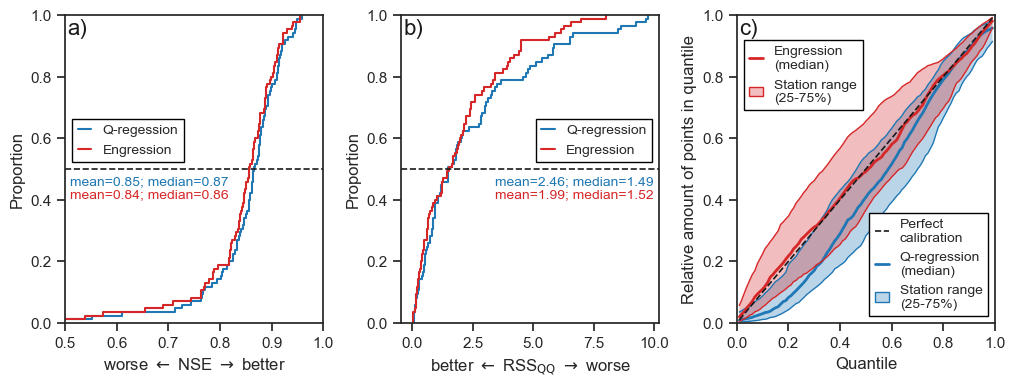

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3, 'hspace': 0.25})

######## Plot NSE ########

ax = axes[0]

sns.ecdfplot(data=metric_exp_df, x='NSE', color='tab:blue', label='Q-regession', ax=ax)
sns.ecdfplot(data=metric_eng_df, x='NSE', color='tab:red', label='Engression', ax=ax)

ax.text(0.02, 0.48, f'mean={metric_exp_df.NSE.mean():0.2f}; median={metric_exp_df.NSE.median():0.2f}',
        transform=ax.transAxes, va='top', ha='left', color='tab:blue', fontsize=10)
ax.text(0.02, 0.48, f'\nmean={metric_eng_df.NSE.mean():0.2f}; median={metric_eng_df.NSE.median():0.2f}',
        transform=ax.transAxes, va='top', ha='left', color='tab:red', fontsize=10)

ax.axhline(0.5, color='k', ls='--', lw=1.2)

ax.set_xlim(0.5, 1)
ax.set_xlabel(r'worse $\leftarrow$ NSE $\rightarrow$ better')
ax.set_ylabel('Proportion')

# Put legend top center:
ax.legend(loc='lower left', bbox_to_anchor=(0., 0.5), handlelength=1.0)

######## Plot FDC ########

# ax = axes[0, 1]

# sns.boxplot(box_data, x='interval', y='value', hue='source', ax=ax, showfliers=False,
#             palette=['tab:blue', 'tab:red'], boxprops=dict(alpha=.5),
#             width=0.8, gap=0.3, legend='brief', saturation=1)

# import matplotlib.patches as mpatches
# # grab only the PathPatch objects that are the actual boxes
# boxes = [p for p in ax.patches if isinstance(p, mpatches.PathPatch)]

# lines_per_box = len(ax.lines) // len(boxes)   # works whether flier lines exist or not

# for i, box in enumerate(boxes):
#     col = box.get_facecolor()
#     # new_col = (*col[:3], 1.0)
#     new_col = blend_with_alpha(col, alpha=0.3)

#     box.set_edgecolor(col)
#     box.set_facecolor(new_col)                 # optional: keep boxes hollow

#     start = i * lines_per_box
#     for line in ax.lines[start:start + lines_per_box]:
#         line.set_color(col)
#         line.set_mfc(col)                     # face colour of fliers (if any)
#         line.set_mec(col)                     # edge colour of fliers

# ax.axhline(0.5, color='k', ls='--', lw=1.2, zorder=100)

# ax.set_xticks((np.arange(len(bounds)) - 0.5)[::3])
# ax.set_xticklabels((np.arange(0, 1.001, 0.2)).round(1));

# ax.legend_.set_title(None)

# ax.set_xlabel('Quantile')
# ax.set_ylabel('%Bias')
# # ax.set_ylim(None, 55)

# # Put legend top center:
# legend = ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), handlelength=1.0)

# for legpatch in legend.get_patches():
#     col = legpatch.get_facecolor()
#     legpatch.set_edgecolor(col)

# blend_legend_color_with_alpha(legend=legend, indices=[0, 1], alpha=0.3)

######## Plot RSS ########

ax = axes[1]

sns.ecdfplot(data=metric_exp_df, x='RSS', color='tab:blue', label='Q-regression', ax=ax)
sns.ecdfplot(data=metric_eng_df, x='RSS', color='tab:red', label='Engression', ax=ax)

ax.text(0.98, 0.48, f'mean={metric_exp_df.RSS.mean():0.2f}; median={metric_exp_df.RSS.median():0.2f}',
        transform=ax.transAxes, va='top', ha='right', color='tab:blue', fontsize=10)
ax.text(0.98, 0.48, f'\nmean={metric_eng_df.RSS.mean():0.2f}; median={metric_eng_df.RSS.median():0.2f}',
        transform=ax.transAxes, va='top', ha='right', color='tab:red', fontsize=10)

ax.axhline(0.5, color='k', ls='--', lw=1.2)

ax.set_xlabel(r'better $\leftarrow$ RSS$_\mathrm{QQ}$ $\rightarrow$ worse')

ax.set_ylabel('Proportion')

# Put legend top center:
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.5), handlelength=1.0)

######## Plot Calibration ########

ax = axes[2]

for i, (cdf, name_nice) in enumerate(zip([cdf_exp.cdf, cdf_eng.cdf], ['Q-regression', 'Engression'])):
    x = np.arange(start=0.01, stop=1.0, step=0.01)

    if i == 0:
        color = 'tab:blue'
        sns.lineplot(x=x, y=x, ax=ax, label=f'Perfect\ncalibration', color='k', linestyle='--', lw=1.2, zorder=-5)
    else:
        color = 'tab:red'

    med = np.median(cdf, axis=0)
    low = np.quantile(cdf, 0.25, axis=0)
    high = np.quantile(cdf, 0.75, axis=0)

    sns.lineplot(x=x, y=med, ax=ax, label=f'{name_nice}\n(median)', color=color, zorder=-10, lw=2)
    sns.lineplot(x=x, y=low, ax=ax, color=color, zorder=-10, lw=1)
    sns.lineplot(x=x, y=high, ax=ax, color=color, zorder=-10, lw=1)

    ax.fill_between(
        x=x, y1=low, y2=high, ec='none', fc=color, alpha=0.3, zorder=-20, label=f'Station range\n(25-75%)')

ax.set_rasterization_zorder(-5)
ax.set_xlabel('Quantile')
ax.set_ylabel('Relative amount of points in quantile')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

handles, labels = ax.get_legend_handles_labels()
legend0 = ax.legend(handles[3:], labels[3:],  loc='upper left', bbox_to_anchor=(0.0, 0.94), handlelength=1.0)
blend_legend_color_with_alpha(legend=legend0, indices=[1], alpha=0.3)
plt.gca().add_artist(legend0)
legend1 = ax.legend(handles[:3], labels[:3],  loc='lower right', bbox_to_anchor=(1.0, 0.0), handlelength=1.0)
blend_legend_color_with_alpha(legend=legend1, indices=[2], alpha=0.3)

for legpatch in legend0.get_patches():
    legpatch.set_edgecolor('tab:red')
for legpatch in legend1.get_patches():
    legpatch.set_edgecolor('tab:blue')

for ax , label in zip(axes.flat, ['a)', 'b)', 'c)']):
    ax.annotate(label, xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
                ha='left', va='top', color='k')

fig.align_ylabels()

fig.savefig(SAVE_DIR / 'calibration_plot.eps', dpi=300, bbox_inches='tight')